In [1]:
import pandas
import tensorflow as tf
print(tf.__version__)

2.1.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [3]:
# Save the input and target variables
# print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

Xtrain , Xtest , ytrain, ytest = train_test_split(data, targets, test_size = 0.1)

print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential ([
        Dense(128, activation = 'relu', input_shape = (Xtrain.shape[1],)),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(1)
    ])
    return model

model = get_model()

In [7]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model

model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])

In [9]:
# Train the model, with some of the data reserved for validation

history = model.fit(Xtrain, ytrain, epochs = 100, validation_split = 0.15, batch_size = 64, verbose = False)

In [10]:
# Evaluate the model on the test set

model.evaluate(Xtest, ytest, verbose = 2)

45/45 - 0s - loss: 0.7965 - mae: 0.6655


[0.7965465068817139, 0.6654634]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

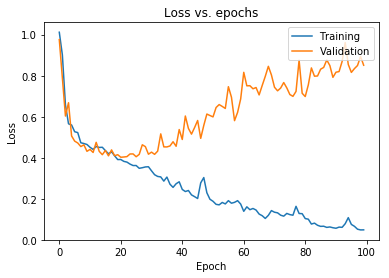

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu", input_shape=(Xtrain.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5,0.3)

In [16]:
# Compile the model

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mae'])

In [17]:
# Train the model, with some of the data reserved for validation

history = model.fit(Xtrain, ytrain, epochs = 100, validation_split = 0.15, batch_size = 64, verbose = False)
pandas.DataFrame(history.history)

,loss,mae,val_loss,val_mae
0,0.871069,0.864508,0.888572,0.882029
1,0.858899,0.852366,0.888899,0.882379
2,0.837592,0.831077,0.873248,0.866741
3,0.803652,0.797147,0.828273,0.821770
4,0.763212,0.756707,0.775210,0.768704
...,...,...,...,...
95,0.488648,0.482297,0.594513,0.588160
96,0.494414,0.488061,0.586563,0.580210
97,0.468716,0.462363,0.589234,0.582878
98,0.479837,0.473479,0.592887,0.586529


In [18]:
# Evaluate the model on the test set

model.evaluate(Xtest, ytest, verbose = 2)

45/45 - 0s - loss: 0.6557 - mae: 0.6494


[0.6557335522439744, 0.649377]

#### Plot the learning curves

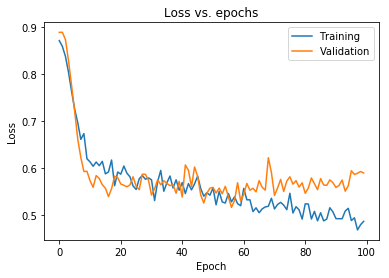

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### Batch Regularization

In [20]:
# Add a customised batch normalisation layer

# model.add(tf.keras.layers.BatchNormalization(
#     momentum=0.95, 
#     epsilon=0.005,
#     axis = -1,
#     beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
#     gamma_initializer=tf.keras.initializers.Constant(value=0.9)
# ))

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [21]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    def on_train_begin(self, logs = None):
        print("Starting Training ...")
        
    def on_epoch_begin(self, epoch, logs = None):
        print(f"Starting Epoch {epoch}")
    
    def on_train_batch_begin(self, batch, logs = None):
        print(f"Training: Starting Batch {batch}")
        
    def on_train_batch_end(self, batch, logs = None):
        print(f"Training: Finished Batch {batch}")

    def on_epoch_end(self, epoch, logs = None):
        print(f"Finished Epoch {epoch}")
        
    def on_train_end(self, logs = None):
        print("Finished Training")
        
    def on_test_begin(self, logs = None):
        print("Starting Testing ...")
    
    def on_test_batch_begin(self, batch, logs = None):
        print(f"Testing: Starting Batch {batch}")
        
    def on_test_batch_end(self, batch, logs = None):
        print(f"Testing: Finished Batch {batch}")
        
    def on_test_end(self, logs = None):
        print("Finished Testing")
        
    def on_predict_begin(self, logs = None):
        print("Starting Prediction ...")
    
    def on_predict_batch_begin(self, batch, logs = None):
        print(f"Prediction: Starting Batch {batch}")
        
    def on_predict_batch_end(self, batch, logs = None):
        print(f"Prediction: Finished Batch {batch}")
        
    def on_predict_end(self, logs = None):
        print("Finished Prediction")

In [22]:
# Re-build the model

model = get_regularised_model(1e-5,0.3)

In [23]:
# Compile the model

model.compile(optimizer = 'adam', loss = 'mae')

#### Train the model with the callback

In [24]:
# Train the model, with some of the data reserved for validation

model.fit(Xtrain, ytrain, epochs = 5, batch_size = 128, verbose = False, callbacks = [TrainingCallback()])

Starting Training ...
Starting Epoch 0
Training: Starting Batch 0
Training: Finished Batch 0
Training: Starting Batch 1
Training: Finished Batch 1
Training: Starting Batch 2
Training: Finished Batch 2
Training: Starting Batch 3
Training: Finished Batch 3
Finished Epoch 0
Starting Epoch 1
Training: Starting Batch 0
Training: Finished Batch 0
Training: Starting Batch 1
Training: Finished Batch 1
Training: Starting Batch 2
Training: Finished Batch 2
Training: Starting Batch 3
Training: Finished Batch 3
Finished Epoch 1
Starting Epoch 2
Training: Starting Batch 0
Training: Finished Batch 0
Training: Starting Batch 1
Training: Finished Batch 1
Training: Starting Batch 2
Training: Finished Batch 2
Training: Starting Batch 3
Training: Finished Batch 3
Finished Epoch 2
Starting Epoch 3
Training: Starting Batch 0
Training: Finished Batch 0
Training: Starting Batch 1
Training: Finished Batch 1
Training: Starting Batch 2
Training: Finished Batch 2
Training: Starting Batch 3
Training: Finished Bat

In [25]:
# Evaluate the model

model.evaluate(Xtest, ytest, verbose = 2, callbacks = [TrainingCallback()])

Starting Testing ...
Testing: Starting Batch 0
Testing: Finished Batch 0
Testing: Starting Batch 1
Testing: Finished Batch 1
45/45 - 0s - loss: 0.6386
Finished Testing


0.6386317213376363

In [26]:
# Make predictions with the model

model.predict(Xtest, verbose = 2, callbacks = [TrainingCallback()])

Starting Prediction ...
Prediction: Starting Batch 0
Prediction: Finished Batch 0
Prediction: Starting Batch 1
Prediction: Finished Batch 1
45/45 - 0s
Finished Prediction


array([[-0.428048  ],
       [-0.4285773 ],
       [-0.0466413 ],
       [-0.12660429],
       [-0.23407322],
       [-0.33323854],
       [-0.2201007 ],
       [-0.44839996],
       [-0.1068735 ],
       [-0.3708073 ],
       [-0.24675119],
       [-0.02764835],
       [-0.17284098],
       [-0.33612978],
       [-0.33231592],
       [-0.44842497],
       [ 0.02216942],
       [-0.11360173],
       [-0.312776  ],
       [-0.03013854],
       [ 0.0913758 ],
       [-0.01680593],
       [-0.37993312],
       [-0.09574983],
       [-0.27537936],
       [-0.34853008],
       [-0.02503996],
       [ 0.02439876],
       [-0.31398246],
       [-0.3178183 ],
       [ 0.01561159],
       [ 0.02003927],
       [-0.22038057],
       [-0.04213703],
       [-0.3331607 ],
       [-0.3186345 ],
       [-0.04188385],
       [-0.28994796],
       [-0.05270149],
       [-0.34911492],
       [-0.43158525],
       [-0.19544491],
       [-0.01495611],
       [-0.36758626],
       [ 0.05621792]], dtype=flo

#### Logs Dictionary

In [27]:
# Define the learning rate schedule. The tuples below are (start_epoch, new_learning_rate)

# lr_schedule = [
#     (4, 0.03), (7, 0.02), (11, 0.005), (15, 0.007)
# ]

# def get_new_epoch_lr(epoch, lr):
#     # Checks to see if the input epoch is listed in the learning rate schedule 
#     # and if so, returns index in lr_schedule
#     epoch_in_sched = [i for i in range(len(lr_schedule)) if lr_schedule[i][0]==int(epoch)]
#     if len(epoch_in_sched)>0:
#         # If it is, return the learning rate corresponding to the epoch
#         return lr_schedule[epoch_in_sched[0]][1]
#     else:
#         # Otherwise, return the existing learning rate
#         return lr

In [28]:
# Define the custom callback

# class LRScheduler(tf.keras.callbacks.Callback):
    
#     def __init__(self, new_lr):
#         super(LRScheduler, self).__init__()
#         # Add the new learning rate function to our callback
#         self.new_lr = new_lr

#     def on_epoch_begin(self, epoch, logs=None):
#         # Make sure that the optimizer we have chosen has a learning rate, and raise an error if not
#         if not hasattr(self.model.optimizer, 'lr'):
#               raise ValueError('Error: Optimizer does not have a learning rate.')
                
#         # Get the current learning rate
#         curr_rate = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        
#         # Call the auxillary function to get the scheduled learning rate for the current epoch
#         scheduled_rate = self.new_lr(epoch, curr_rate)

#         # Set the learning rate to the scheduled learning rate
#         tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_rate)
#         print('Learning rate for epoch {} is {:7.3f}'.format(epoch, scheduled_rate))

In [29]:
# Fit the model with our learning rate scheduler callback

# new_history = new_model.fit(train_data, train_targets, epochs=20,
#                             batch_size=100, callbacks=[LRScheduler(get_new_epoch_lr)], verbose=False)

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [30]:
# Re-train the unregularised model

unregularized_model = get_model()
unregularized_model.compile(optimizer = 'adam', loss = 'mae')
unreg_history = unregularized_model.fit(Xtrain, ytrain, epochs = 100,
                                        validation_split = 0.15, batch_size = 64, verbose = False,
                                        callbacks = [tf.keras.callbacks.EarlyStopping()])

In [31]:
# Evaluate the model on the test set

unregularized_model.evaluate(Xtest, ytest, verbose = 2)

45/45 - 0s - loss: 0.5750


0.5749921109941271

In [32]:
# Re-train the regularised model

regularized_model = get_regularised_model(1e-8,0.2)
regularized_model.compile(optimizer = 'adam', loss = 'mae')
reg_history = regularized_model.fit(Xtrain, ytrain, epochs = 100,
                                        validation_split = 0.15, batch_size = 64, verbose = False,
                                        callbacks = [tf.keras.callbacks.EarlyStopping()])

In [33]:
# Evaluate the model on the test set

regularized_model.evaluate(Xtest, ytest, verbose = 2)

45/45 - 0s - loss: 0.5992


0.5991732663578457

#### Plot the learning curves

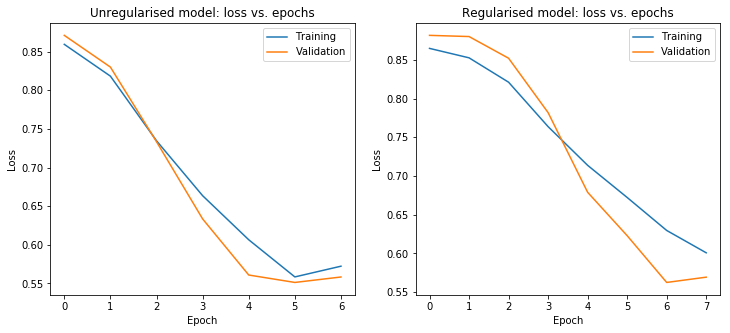

In [34]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()